In [1]:
from glob import glob

In [2]:
glob("ctpel_drr/*")

['ctpel_drr/drr_org', 'ctpel_drr/drr', 'ctpel_drr/mask_org', 'ctpel_drr/mask']

In [80]:
!tar -cvf ctpel_drr.tar ctpel_drr

ctpel_drr/
ctpel_drr/mask/
ctpel_drr/mask/02781BB458B7EEE0_1.png
ctpel_drr/mask/02781BB458B7EEE0_2.png
ctpel_drr/mask/02781BB458B7EEE0_3.png
ctpel_drr/mask/02781BB458B7EEE0_4.png
ctpel_drr/mask/02781BB458B7EEE0_5.png
ctpel_drr/mask/02CC41B35F6C8145_1.png
ctpel_drr/mask/02CC41B35F6C8145_2.png
ctpel_drr/mask/02CC41B35F6C8145_3.png
ctpel_drr/mask/02CC41B35F6C8145_4.png
ctpel_drr/mask/02CC41B35F6C8145_5.png
ctpel_drr/mask/06BE6C20741AFADD_1.png
ctpel_drr/mask/06BE6C20741AFADD_2.png
ctpel_drr/mask/06BE6C20741AFADD_3.png
ctpel_drr/mask/06BE6C20741AFADD_4.png
ctpel_drr/mask/06BE6C20741AFADD_5.png
ctpel_drr/mask/.ipynb_checkpoints/
ctpel_drr/mask/.ipynb_checkpoints/02781BB458B7EEE0_1-checkpoint.png
ctpel_drr/mask/.ipynb_checkpoints/02781BB458B7EEE0_2-checkpoint.png
ctpel_drr/mask/.ipynb_checkpoints/02781BB458B7EEE0_3-checkpoint.png
ctpel_drr/mask/.ipynb_checkpoints/02781BB458B7EEE0_4-checkpoint.png
ctpel_drr/mask/.ipynb_checkpoints/02781BB458B7EEE0_5-checkpoint.png
ctpel_drr/mask/.ipynb_checkp

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom
from PIL import Image
import cv2

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt


IMG_EXTENSION = ['.dcm', '.DCM']


def check_extension(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSION)


def load_scans_path(folder_path):
    """
    find 'IMG_EXTENSION' file paths in folder.
    return list
    
    """
    
    img_paths = []
    assert os.path.isdir(folder_path), '%s is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname):
                path = os.path.join(root, fname)
                img_paths.append(path)
    return img_paths[:]


def load_ct_scans(patient_folder_path):
    """
    Function of Loading CT-scans "per patient"
    patient path to CT slices(HU)
    input: patient folder path -> list or tuple
    output: File Meta Information, CT sclices -> tuple
    """
    # call all image paths in directory
    dcm_paths = load_scans_path(patient_folder_path)
    
    slices = [pydicom.read_file(dcm_path, force=True) for dcm_path in dcm_paths]
    
    # **Sort the slices in ascending order
    
    for idx, sl in enumerate(slices):
        try:
            _ = sl.ImagePositionPatient[2]
        except AttributeError:
            slices.pop(idx)
            print(idx)
        
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        
    # stack slices
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    
    # return header of first dicom and stacked CT slices
    return slices[0], hu_images


def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays


def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image


def windowing(img, window):
    w_level, w_width = window
    w_min = w_level - (w_width / 2)
    w_max = w_level + (w_width / 2)
    window_image = img.copy()
    window_image[window_image < w_min] = w_min
    window_image[window_image > w_max] = w_max

    return window_image
    
    
def dcms_to_imgs(dcms):
    dcms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    images = np.stack([file.pixel_array for file in dcms])
    images = images.astype(np.int16)

    # convert to HU
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    return hu_images


def sample_stack(stacks, cols=10, start_with=0, show_every=1, vmin=-1000, vmax=1000):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[25,rows*3])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].set_title(f'{stacks[ind].get("SeriesNumber")}')
        ax[i//cols,i % cols].imshow(stacks[ind].pixel_array, vmin=vmin, vmax=vmax,cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()
    
    
def imgs_stack(stacks, cols=10, start_with=0, show_every=1):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[40,rows*5])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].imshow(stacks[ind],cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()

In [9]:
BASE_DIR = "./ctpel/*"
path = f"{glob(BASE_DIR)[3]}/im_1/*.dcm"

# Load the DICOM files

In [10]:
slices = []
print(f'glob : {path}')
for fname in glob(path):
    slices.append(pydicom.dcmread(fname, force=True))

print("file count : {}".format(len(glob(path))))
print("success count : {}".format(len(slices)))

glob : ./ctpel/083B371B51E8CC0B/im_1/*.dcm
file count : 631
success count : 631


## ensure they are in the correct order

In [11]:
slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1], reverse=True)

In [17]:
slices[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 61.7.144591986615433264039965614102056040820
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'MIRCTN16NOV2000'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 61.7.144591986615433264039965614102056040820
(0008, 0020) Study Date                          DA: '20140914'
(0008, 0030) Study Time                         

In [21]:
slices[0][0x020, 0x032].value[-1]

'-181.8'

In [22]:
slices[1][0x020, 0x032].value[-1]

'-182.8'

## pixel aspects, assuming all slices are the same

In [23]:
ps = slices[0].PixelSpacing
ss = slices[0][0x020, 0x032][-1] - slices[1][0x020, 0x032][-1]
ax_aspect = ps[1]/ps[0]
sag_aspect = ss/ps[1]
cor_aspect = ss/ps[0]

## create 3D array

In [13]:
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

for i, s in enumerate(slices):
    try:
        img2d = s.pixel_array
        img3d[:, :, i] = img2d
    except:
        print(i, sorted(glob(path)[i]))

## plot 3 orthogonal slices

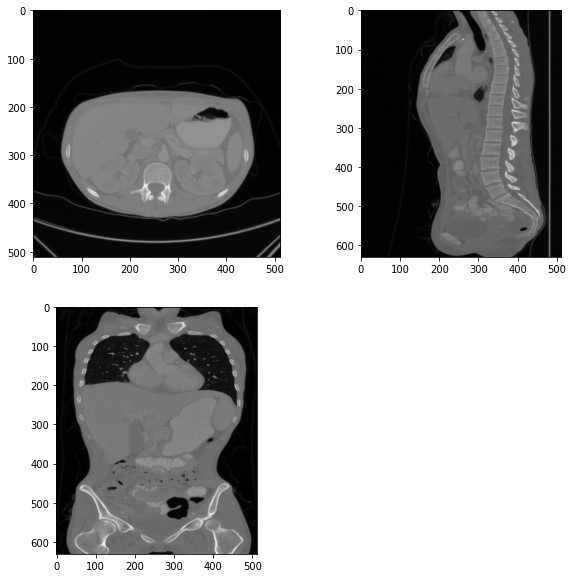

In [14]:
plt.rcParams["figure.figsize"] = (10,10)

a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2], cmap='gray')
# a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :].T, cmap='gray')
# a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T, cmap='gray')
# a3.set_aspect(cor_aspect)

plt.show()

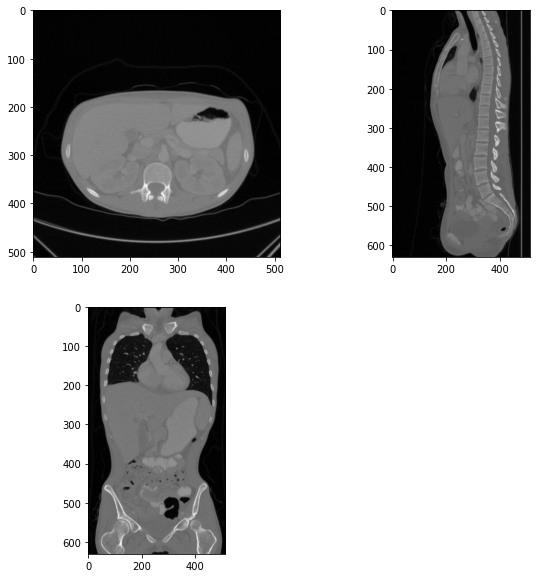

In [24]:
plt.rcParams["figure.figsize"] = (10,10)

a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2], cmap='gray')
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :].T, cmap='gray')
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T, cmap='gray')
a3.set_aspect(cor_aspect)

plt.show()

# averaging slices for coronal view

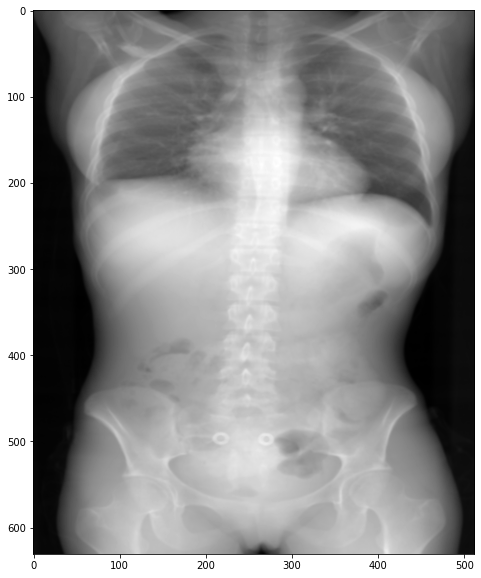

In [25]:
plt.imshow(np.mean(img3d.T, axis=2), cmap='gray')

# Apply Windowing

In [15]:
imgs = dcms_to_imgs(slices)

In [54]:
window_img = windowing(imgs, [600, 1800])

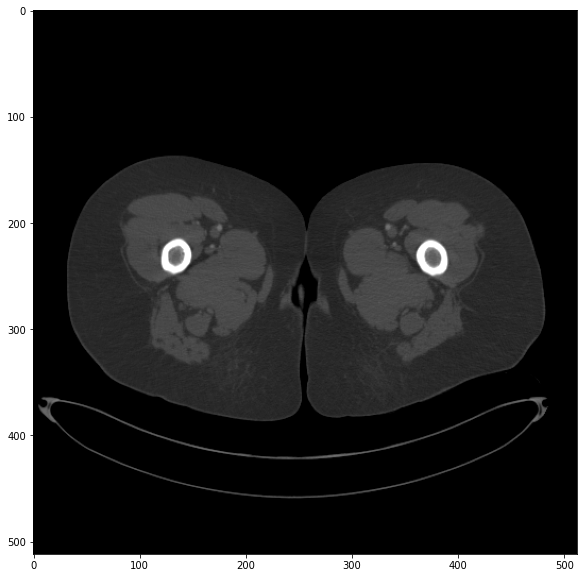

In [17]:
plt.imshow(window_img[0], cmap='gray')

In [55]:
for i, s in enumerate(window_img):
        img3d[:, :, -i] = s

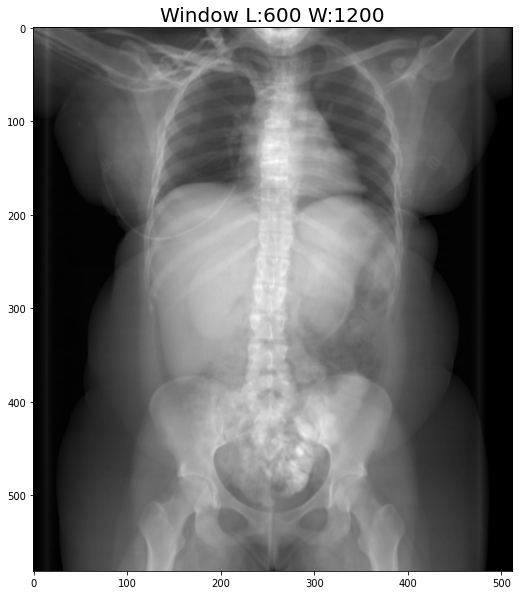

In [127]:
plt.title("Window L:600 W:1800", size=20)
plt.imshow(np.mean(img3d.T, axis=2), cmap='gray')

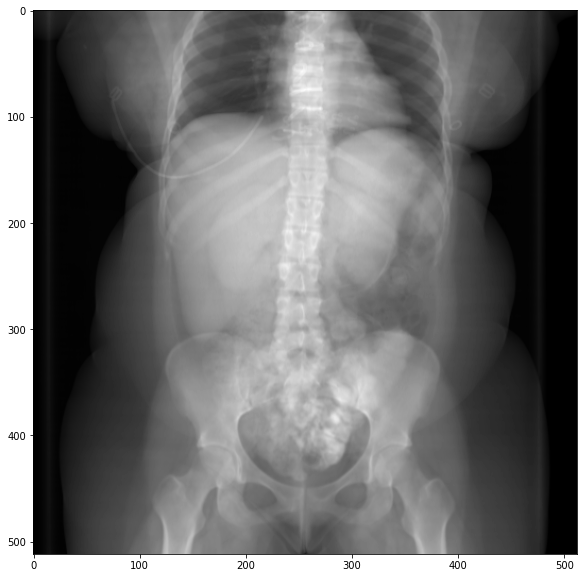

In [56]:
plt.imshow(np.mean(img3d.T, axis=2)[-512:], cmap='gray')

# Match segmentation masks

## extract ROI

In [18]:
mask_path = glob(f"{glob(BASE_DIR)[0]}/im_3/*.dcm")

In [19]:
mask_dcm = pydicom.dcmread(mask_path[0], force=True)

In [20]:
masked_slices = mask_dcm[0x008, 0x1115][0][0x008, 0x114a]

In [21]:
uids_masked = []
for s in tqdm(masked_slices):
    uids_masked.append(s[0x008, 0x1155].value)

212it [00:00, 36578.73it/s]


In [22]:
uids_all = []
for s in tqdm(slices):
    uids_all.append(s[0x008, 0x018].value)

100%|██████████| 581/581 [00:00<00:00, 37325.82it/s]


In [23]:
roi = []
for i in uids_masked:
    roi.append(uids_all.index(i))

In [24]:
roi_slices = slices[min(roi):max(roi)+1]

In [25]:
roi_imgs = dcms_to_imgs(roi_slices)

In [26]:
window_roi_img = windowing(roi_imgs, [600, 1500])

In [27]:
img_shape = list(roi_slices[0].pixel_array.shape)
img_shape.append(len(roi_slices))
roi_img3d = np.zeros(img_shape)

In [28]:
img_shape = list(roi_slices[0].pixel_array.shape)
img_shape.append(len(roi_slices))
roi_img3d = np.zeros(img_shape)

for i, s in enumerate(window_roi_img):
        roi_img3d[:, :, -i] = s

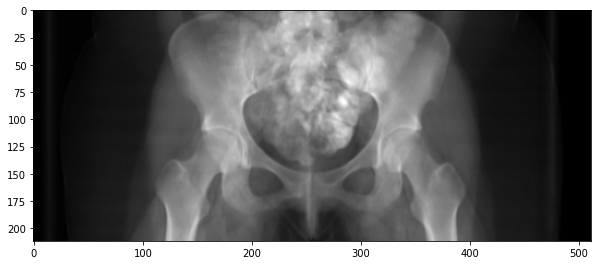

In [29]:
plt.imshow(np.mean(roi_img3d.T, axis=2), cmap='gray')

## change windowing parameters

In [30]:
window_roi_img = windowing(roi_imgs, [600, 1200])
for i, s in enumerate(window_roi_img):
        roi_img3d[:, :, -i] = s

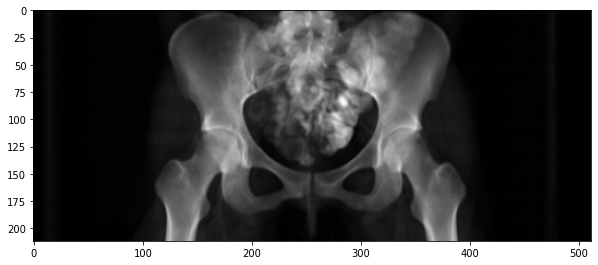

In [31]:
plt.imshow(np.mean(roi_img3d.T, axis=2), cmap='gray')

## extract segmentation masks

In [32]:
segment_dict = {x: [] for x in range(1,6)}
for s in mask_dcm[0x5200, 0x9230]:
    uid = s[0x008, 0x9124][0][0x008, 0x2112][0][0x008, 0x1155].value
    segment_num = s[0x062, 0x00a][0][0x062, 0x00b].value
    
    segment_dict[segment_num].append(uid)

In [33]:
mask_dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 168
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.2423033751.20012.1556534564.99
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.752.24.3.3.25.7
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.2423033751.20012.1556534564.99
(0008, 0020) Study Date                          DA: '20140914'
(0008, 0021) Series Date                         DA: '20190429'
(0008, 0023) Content Date                        DA: '2019

In [34]:
roi_dict = {x: [] for x in range(1,6)}
for seg_num in segment_dict:
    for i in segment_dict[seg_num]:
        roi_dict[seg_num].append(uids_all.index(i))

In [35]:
mask_arr = mask_dcm.pixel_array
segment_arr_dict = dict()
idx = 0
for seg_num in roi_dict:
    seg_img3d = np.zeros(img_shape)
    for i in roi_dict[seg_num]:
        seg_img3d[:, :, -(i+1)] = mask_arr[idx]
        idx += 1
    segment_arr_dict[seg_num] = seg_img3d

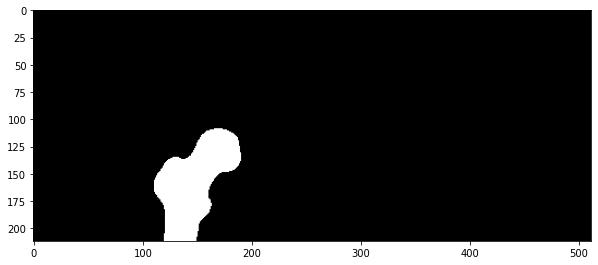

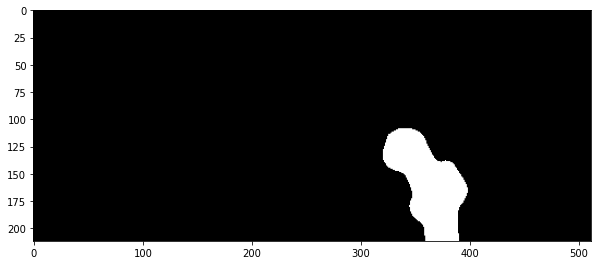

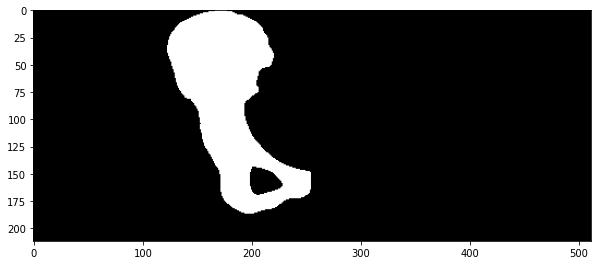

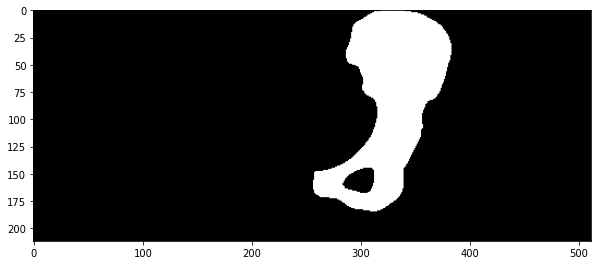

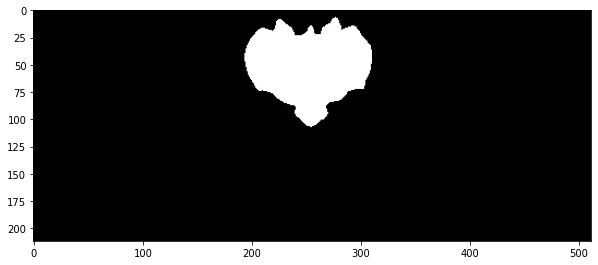

In [36]:
for i in range(1,6):
    plt.imshow(np.max(segment_arr_dict[i].T, axis=2), cmap='gray')
    plt.show()

## visualize

In [37]:
img_dict = dict()
for i in range (1,6):
    img_dict[i]=np.array(np.max(segment_arr_dict[i].T, axis=2)*255).astype(np.uint8)

In [42]:
dim = np.zeros((img_dict[1].shape[0], img_dict[1].shape[1])).astype(np.uint8)
mask_1 = np.stack((dim, dim, img_dict[1]), axis=2)
mask_2 = np.stack((dim, img_dict[2], dim), axis=2)
mask_3 = np.stack((img_dict[3], dim, dim), axis=2)
mask_4 = np.stack((img_dict[4], dim, img_dict[4]), axis=2)
mask_5 = np.stack((img_dict[5], img_dict[5], dim), axis=2)
mask_all = mask_1+mask_2+mask_3+mask_4+mask_5

In [43]:
a = np.zeros((512, 512)).astype(np.uint8)

In [45]:
a = np.stack((a, a, a), axis=2)

In [47]:
a[-212:] = mask_all

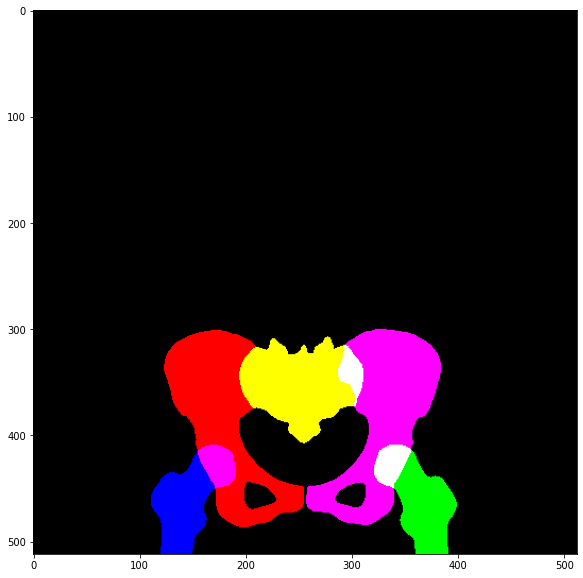

In [49]:
plt.imshow(a)

In [100]:
RGBforLabel = {1:(0,0,255), 
               2:(0,255,0), 
               3:(255,0,0),
               4:(255,0,255),
               5:(255,255,0)}

# Blue -  Right Femur  
# Green - Left Femur  
# Red - Right Hip 
# Purple -  Left Hip
# Yellow - Sacrum

In [101]:
drr_arr = np.mean(roi_img3d.T, axis=2)
drr_arr = (drr_arr - np.min(drr_arr)) / (np.max(drr_arr) - np.min(drr_arr))
drr_arr = cv2.cvtColor(np.float32(drr_arr), cv2.COLOR_GRAY2RGB)

In [103]:
for i in RGBforLabel:
    contours, _ = cv2.findContours(img_dict[i], cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        label = int(i)
        colour = RGBforLabel.get(label)
        cv2.drawContours(drr_arr,[c],-1,colour,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


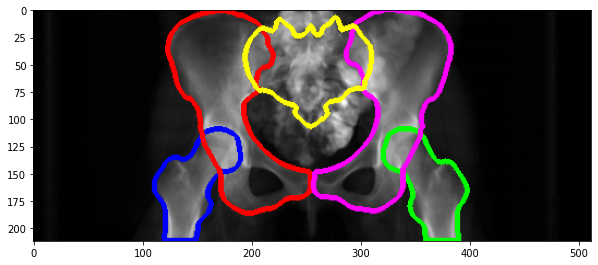

In [104]:
plt.imshow(drr_arr)

# Save to png

In [41]:
for j in range (1,6):
        img_dict[j]=np.array(np.max(segment_arr_dict[j].T, axis=2)*255).astype(np.uint8)
        Image.fromarray(img_dict[j]).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"{glob(BASE_DIR)[0].split('/')[-1]}_{j}.png")
                
drr_arr = np.mean(roi_img3d.T, axis=2)
drr_arr = (drr_arr - np.min(drr_arr)) / (np.max(drr_arr) - np.min(drr_arr))
drr_arr = np.array(drr_arr*255).astype(np.uint8)
Image.fromarray(drr_arr).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"{glob(BASE_DIR)[0].split('/')[-1]}_drr.png")